## **Setup**

In [ ]:
import os
import random
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from google.colab import drive

from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, Input
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers.experimental.preprocessing import Rescaling

from sklearn.metrics import roc_auc_score, roc_curve, auc
from matplotlib.colors import LinearSegmentedColormap
from termcolor import colored

# Set seed for reproducibility of results
seed_value = 0
os.environ['PYTHONHASHSEED']=str(seed_value)
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

tf.compat.v1.reset_default_graph()

random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
tf.compat.v1.set_random_seed(seed_value)

# Configure a new global `tensorflow` session
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

tf.__version__

'2.3.0'

In [ ]:
mount_path = '/content/gdrive/'
drive.mount(mount_path)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [ ]:
# Set and test path to competition data files
competition_path = 'My Drive/Final Project ITC/MAFAT Challenge/Data'
try:
  if competition_path == 'INSERT HERE':
    print('Please enter path to competition data files:')
    competition_path = input()
  file_path = 'MAFAT RADAR Challenge - Training Set V1.csv'
  with open(f'{mount_path}/{competition_path}/{file_path}') as f:
    f.readlines()
  print(colored('Everything is setup correctly', color='green'))
except:
  print(colored('Please mount drive and set competition_path correctly',
                color='red'))

Everything is setup correctly


## **Functions**

All functions will be used in the "Training the Model" section.

### **Data loading**

In [ ]:
# Functions for loading the data
def load_data(file_path):
  """
  Reads all data files (metadata and signal matrix data) as python dictionary,
  the pkl and csv files must have the same file name.

  Arguments:
    file_path -- {str} -- path to the iq_matrix file and metadata file

  Returns:
    Python dictionary
  """
  pkl = load_pkl_data(file_path)
  meta = load_csv_metadata(file_path)
  data_dictionary = {**meta, **pkl}
  
  for key in data_dictionary.keys():
    data_dictionary[key] = np.array(data_dictionary[key])

  return data_dictionary


def load_pkl_data(file_path):
  """
  Reads pickle file as a python dictionary (only Signal data).

  Arguments:
    file_path -- {str} -- path to pickle iq_matrix file

  Returns:
    Python dictionary
  """
  path = os.path.join(mount_path, competition_path, file_path + '.pkl')
  with open(path, 'rb') as data:
    output = pickle.load(data)
  return output


def load_csv_metadata(file_path):
  """
  Reads csv as pandas DataFrame (only Metadata).

  Arguments:
    file_path -- {str} -- path to csv metadata file

  Returns:
    Pandas DataFarme
  """
  path = os.path.join(mount_path, competition_path, file_path + '.csv')
  with open(path, 'rb') as data:
    output = pd.read_csv(data)
  return output

## **Data Preprocessing**  
   



In [ ]:
# Functions for preprocessing and preprocess function
def fft(iq, axis=0):
  """
  Computes the log of discrete Fourier Transform (DFT).
     
  Arguments:
    iq_burst -- {ndarray} -- 'iq_sweep_burst' array
    axis -- {int} -- axis to perform fft in (Default = 0)

  Returns:
    log of DFT on iq_burst array
  """
  iq = np.log(np.abs(np.fft.fft(hann(iq), axis=axis)))
  return iq


def hann(iq, window=None):
    """
    Preformes Hann smoothing of 'iq_sweep_burst'.

    Arguments:
      iq {ndarray} -- 'iq_sweep_burst' array
      window -{range} -- range of hann window indices (Default=None)
               if None the whole column is taken

    Returns:
      Regulazied iq in shape - (window[1] - window[0] - 2, iq.shape[1])
    """
    if window is None:
        window = [0, len(iq)]

    N = window[1] - window[0] - 1
    n = np.arange(window[0], window[1])
    n = n.reshape(len(n), 1)
    hannCol = 0.5 * (1 - np.cos(2 * np.pi * (n / N)))
    return (hannCol * iq[window[0]:window[1]])[1:-1]


def max_value_on_doppler(iq, doppler_burst):
  """
  Set max value on I/Q matrix using doppler burst vector. 
     
  Arguments:
    iq_burst -- {ndarray} -- 'iq_sweep_burst' array
    doppler_burst -- {ndarray} -- 'doppler_burst' array (center of mass)
               
  Returns:
    I/Q matrix with the max value instead of the original values
    The doppler burst marks the matrix values to change by max value
  """
  iq_max_value = np.max(iq)
  for i in range(iq.shape[1]):
    if doppler_burst[i]>=len(iq):
       continue
    iq[doppler_burst[i], i] = iq_max_value
  return iq


def normalize(iq):
  """
  Calculates normalized values for iq_sweep_burst matrix:
  (vlaue-mean)/std.
  """
  m = iq.mean()
  s = iq.std()
  return (iq-m)/s


def data_preprocess(data):
  """
  Preforms data preprocessing.
  Change target_type lables from string to integer:
  'human'  --> 1
  'animal' --> 0

  Arguments:
    data -- {ndarray} -- the data set

  Returns:
    processed data (max values by doppler burst, DFT, normalization)
  """
  X=[]
  for i in range(len(data['iq_sweep_burst'])):
    iq = fft(data['iq_sweep_burst'][i])
    iq = max_value_on_doppler(iq,data['doppler_burst'][i])
    iq = normalize(iq)
    X.append(iq)

  data['iq_sweep_burst'] = np.array(X)
  if 'target_type' in data:
    data['target_type'][data['target_type'] == 'animal'] = 0
    data['target_type'][data['target_type'] == 'human'] = 1
  return data

### functions for data augmentation

In [ ]:
def shift_spectrogram(iq_array, shift=16):
  """
  The funtion return the spectoram shifted by the given value 
  the max value = 31 - must be only for one segment
  """
  return np.concatenate((iq_array[:, shift:], iq_array[:, :shift]), axis=1)

def plot_shited_spectrogram(iq, shift):
    """
    plot the original spectrogram vs the augmentation. shifting by given value
    the plot is after the preprocess of the baseline
    """
    pixel_shift = 0.5
    cm_data = np.load('/content/cmap.npy')
    color_map = LinearSegmentedColormap.from_list('parula', cm_data)

    iq_shifted = shift_spectrogram(iq, shift=shift)

    plt.subplot(1, 2, 1); plt.imshow(iq, cmap=color_map); plt.title("orginal")
    plt.subplot(1, 2, 2); plt.imshow(iq_shifted, cmap=color_map); plt.title(f"shifted by {shift}")



In [ ]:
def recenter_midline(radar_array):
  """
  This function shifts the spectogram by 63 (half) upwards so that the center of
  the spectogram matches the center position. Anything above means going towards
  and values bellow mean the object is going away.
  """
  center = int(radar_array.shape[0]/2)
  center_radar = np.concatenate((radar_array[center:],radar_array[:center]))
  return center_radar

def plot_recenter_midline_spectrogram(iq):
    """
    plot the original spectrogram vs the augmentation. shifting by given value
    the plot is after the preprocess of the baseline
    """
    pixel_shift = 0.5
    cm_data = np.load('/content/cmap.npy')
    color_map = LinearSegmentedColormap.from_list('parula', cm_data)

    iq_recenter = recenter_midline(iq)

    plt.subplot(1, 2, 1); plt.imshow(iq, cmap=color_map); plt.title("orginal")
    plt.subplot(1, 2, 2); plt.imshow(iq_recenter, cmap=color_map); plt.title(f"recenter spectrogram")


### Image Data Generator

**width_shift_range**:

 It actually shift the image to the left or right(horizontal shifts). If the value is float and <=1 it will take the percentage of total width as range. Suppose image width is 100px. if width_shift_range = 1.0 it will take -100% to +100% means -100px to +100px. It will shift image randomly between this range



**height_shift_range**: It works same as width_shift_range but shift vertically(up or down)

**fill_mode**: One of {"constant", "nearest", "reflect" or "wrap"}. 

Points outside the boundaries of the input are filled according to the given mode:
- "constant": kkkkkkkk|abcd|kkkkkkkk (cval=k)
- "nearest":  aaaaaaaa|abcd|dddddddd
- "reflect":  abcddcba|abcd|dcbaabcd
- "wrap":  abcdabcd|abcd|abcdabcd


**brightness_range**
- The brightness of the image can be augmented by either randomly darkening images, brightening images, or both.
- The intent is to allow a model to generalize across images trained on different lighting levels.
- This can be achieved by specifying the brightness_range argument to the ImageDataGenerator() constructor that specifies min and max range as a float representing a percentage for selecting a brightening amount.
- Values less than 1.0 darken the image, e.g. [0.5, 1.0], whereas values larger than 1.0 brighten the image, e.g. [1.0, 1.5], where 1.0 has no effect on brightness.

**preprocessing_function**:
- function that will be applied on each input. The function will run after the image is resized and augmented. 
- The function should take one argument: one image (Numpy tensor with rank 3), and should output a Numpy tensor with the same shape.



### **Splitting the Training set**

The functions below split the training set into Train and Validation sets.

* Validation Set.   
The validation set is constructed from segments from geolocation_ids 1 and 4.   
These geolocations' target_type distributions are balanced.
To create a fair representation of the test set   
(one segment form each track) every sixth segment was taken to the validation set.   
The reason is that approximately 75% of the tracks have less than 6 segments,   
it guarantees that most of the segments in the validation set are not from the same track.   
   
* Adding "human" segments to the training set.   
The training set is imbalanced.   
One can address this issue by taking segements of humans from the "Auxiliary Experiment Set".   
The first 3 segments from each track are taken into the training set (or less if the track is shorter than 3 segments).

In [ ]:
# Function for splitting the data to training and validation
# and function for selecting samples of segments from the Auxiliary dataset
def split_train_val(data):
  """
  Split the data to train and validation set.
  The validation set is built from training set segments of 
  geolocation_id 1 and 4. 
  Use the function only after the training set is complete and preprocessed. 

  Arguments:
    data -- {ndarray} -- the data set to split

  Returns:
    iq_sweep_burst ndarray matrices
    target_type vector 
    for training and validation sets
  """
  idx = ((data['geolocation_id'] == 4) | (data['geolocation_id'] == 1))\
   & (data['segment_id'] % 6 == 0)
  training_x = data['iq_sweep_burst'][np.logical_not(idx)]
  training_y = data['target_type'][np.logical_not(idx)]
  validation_x = data['iq_sweep_burst'][idx]
  validation_y = data['target_type'][idx]
  return training_x, training_y, validation_x, validation_y

def aux_split(data):
  """
  Selects segments from the auxilary set for training set.
  Takes the first 3 segments (or less) from each track.

  Arguments:
    data {dataframe} -- the auxilary data

  Returns:
    The auxilary data for the training
  """
  idx = np.bool_(np.zeros(len(data['track_id'])))
  for track in np.unique(data['track_id']):
    idx |= data['segment_id']==(data['segment_id'][data['track_id'] == track][:3])
  
  for key in data:
    data[key] = data[key][idx]
  return data

## **Model**

In [ ]:
import tensorflow as tf
from sklearn.metrics import classification_report
from tensorflow.keras.applications import ResNet50, VGG19, InceptionResNetV2
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet50_preprocess_input
from tensorflow.keras.applications.vgg19 import preprocess_input as vgg19_preprocess_input
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input as inception_resnet_v2_preprocess_input

### **CNN Model** - transfer learning


In [ ]:
# Building the model
def create_model(model_tl, input_shape= (126, 32, 3)):
  """
  Transfer learning Resnet model. trained on imagenet
  The input shape must be RGB, hense we must duplicate the channel 3 times

  Arguments:
    input_shape -- the shape of our input
    init -- the weight initialization

  Returns:
    CNN model - with resnet inside  
  """
  tl_model = Sequential(name="transfer_learning_model")
  tl_model.add(Input(shape=input_shape))
  tl_model.add(model_tl(include_top=False, weights="imagenet", pooling='avg'))
  # tl_model.add(Dense(256,activation=('relu'))) 
  # tl_model.add(Dropout(.2))
  # tl_model.add(Dense(128,activation=('relu')))
  # tl_model.add(Dropout(.2))

  tl_model.add(Dense(1, activation="sigmoid"))

  # Say not to train first layer (ResNet) model. It is already trained
  tl_model.layers[0].trainable = False
  return tl_model

### **Evaluation and Visualization of Model's results**

In [ ]:
# Function for calculating the final ROC-AUC score and plot the ROC curve,
# used in the "Results" section
def stats(pred, actual):
  """
  Computes the model ROC-AUC score and plots the ROC curve.

  Arguments:
    pred -- {ndarray} -- model's probability predictions
    actual -- the true lables

  Returns:
    ROC curve graph and ROC-AUC score
  """
  plt.figure(figsize=(20, 10))
  fpr1, tpr1, _ = roc_curve(actual[0], pred[0])
  fpr2, tpr2, _ = roc_curve(actual[1], pred[1])
  roc_auc = [auc(fpr1, tpr1), auc(fpr2, tpr2)]
  lw = 2
  plt.plot(fpr1, tpr1, lw=lw, label='Training set (ROC-AUC = %0.2f)' % roc_auc[0])
  plt.plot(fpr2, tpr2, lw=lw, label='Validation set (ROC-AUC = %0.2f)' % roc_auc[1])
  plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--', label = 'Random guess')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate', fontsize=18)
  plt.ylabel('True Positive Rate', fontsize=18)
  plt.title('Training set vs. Validation set ROC curves')
  plt.legend(loc="lower right", prop = {'size': 20})
  plt.show()

## **Training The Model**

In [ ]:
# Loading and preparing the data

# Loading Auxiliary Experiment set - can take a few minutes
experiment_auxiliary = 'MAFAT RADAR Challenge - Auxiliary Experiment Set V2'
experiment_auxiliary_df = load_data(experiment_auxiliary)

In [ ]:
# Taking sample from the Auxiliary Experiment set
train_aux = aux_split(experiment_auxiliary_df)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


In [ ]:
# The function append_dict is for concatenating the training set 
# with the Auxiliary data set segments

def append_dict(dict1, dict2):
  for key in dict1:
    dict1[key] = np.concatenate([dict1[key], dict2[key]], axis=0)
  return dict1

In [ ]:
# Training set
train_path = 'MAFAT RADAR Challenge - Training Set V1'
training_df = load_data(train_path)

# Adding segments from the experiment auxiliary set to the training set
train_df = append_dict(training_df, train_aux)

# Preprocessing and split the data to training and validation
train_df = data_preprocess(train_df.copy())
train_x, train_y, val_x, val_y = split_train_val(train_df)

val_y =  val_y.astype(int)
train_y = train_y.astype(int)

In [ ]:
train_generator = ImageDataGenerator(
                                     vertical_flip = True,
                                     horizontal_flip=True,
                                     width_shift_range = 0.15,
                                    height_shift_range=0.05,
                                    fill_mode='nearest',
                                    brightness_range = [0.7,1.1],
                                    preprocessing_function = None
                                    )


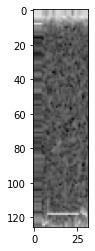

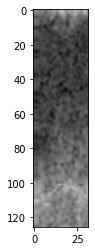

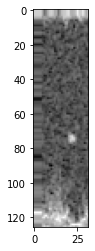

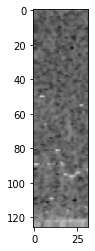

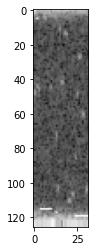

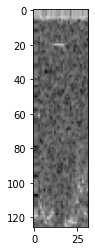

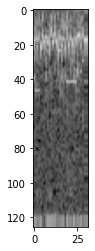

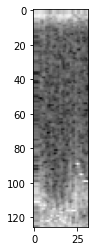

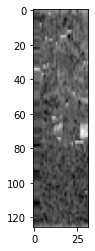

In [ ]:
cm_data = np.load('/content/cmap.npy')
color_map = LinearSegmentedColormap.from_list('parula', cm_data)

for X_batch, y_batch in train_generator.flow(train_x, train_y, batch_size= 9):
    for i in range(0, 9):
      plt.subplot(1, 2, 1); plt.imshow(np.uint8(X_batch[i]), cmap=color_map);plt.show()
    break

check data augmnetation

In [ ]:
#@title
spectrogram_cmap = np.array([[2.422e-01, 1.504e-01, 6.603e-01],
       [2.444e-01, 1.534e-01, 6.728e-01],
       [2.464e-01, 1.569e-01, 6.847e-01],
       [2.484e-01, 1.607e-01, 6.961e-01],
       [2.503e-01, 1.648e-01, 7.071e-01],
       [2.522e-01, 1.689e-01, 7.179e-01],
       [2.540e-01, 1.732e-01, 7.286e-01],
       [2.558e-01, 1.773e-01, 7.393e-01],
       [2.576e-01, 1.814e-01, 7.501e-01],
       [2.594e-01, 1.854e-01, 7.610e-01],
       [2.611e-01, 1.893e-01, 7.719e-01],
       [2.628e-01, 1.932e-01, 7.828e-01],
       [2.645e-01, 1.972e-01, 7.937e-01],
       [2.661e-01, 2.011e-01, 8.043e-01],
       [2.676e-01, 2.052e-01, 8.148e-01],
       [2.691e-01, 2.094e-01, 8.249e-01],
       [2.704e-01, 2.138e-01, 8.346e-01],
       [2.717e-01, 2.184e-01, 8.439e-01],
       [2.729e-01, 2.231e-01, 8.528e-01],
       [2.740e-01, 2.280e-01, 8.612e-01],
       [2.749e-01, 2.330e-01, 8.692e-01],
       [2.758e-01, 2.382e-01, 8.767e-01],
       [2.766e-01, 2.435e-01, 8.840e-01],
       [2.774e-01, 2.489e-01, 8.908e-01],
       [2.781e-01, 2.543e-01, 8.973e-01],
       [2.788e-01, 2.598e-01, 9.035e-01],
       [2.794e-01, 2.653e-01, 9.094e-01],
       [2.798e-01, 2.708e-01, 9.150e-01],
       [2.802e-01, 2.764e-01, 9.204e-01],
       [2.806e-01, 2.819e-01, 9.255e-01],
       [2.809e-01, 2.875e-01, 9.305e-01],
       [2.811e-01, 2.930e-01, 9.352e-01],
       [2.813e-01, 2.985e-01, 9.397e-01],
       [2.814e-01, 3.040e-01, 9.441e-01],
       [2.814e-01, 3.095e-01, 9.483e-01],
       [2.813e-01, 3.150e-01, 9.524e-01],
       [2.811e-01, 3.204e-01, 9.563e-01],
       [2.809e-01, 3.259e-01, 9.600e-01],
       [2.807e-01, 3.313e-01, 9.636e-01],
       [2.803e-01, 3.367e-01, 9.670e-01],
       [2.798e-01, 3.421e-01, 9.702e-01],
       [2.791e-01, 3.475e-01, 9.733e-01],
       [2.784e-01, 3.529e-01, 9.763e-01],
       [2.776e-01, 3.583e-01, 9.791e-01],
       [2.766e-01, 3.638e-01, 9.817e-01],
       [2.754e-01, 3.693e-01, 9.840e-01],
       [2.741e-01, 3.748e-01, 9.862e-01],
       [2.726e-01, 3.804e-01, 9.881e-01],
       [2.710e-01, 3.860e-01, 9.898e-01],
       [2.691e-01, 3.916e-01, 9.912e-01],
       [2.670e-01, 3.973e-01, 9.924e-01],
       [2.647e-01, 4.030e-01, 9.935e-01],
       [2.621e-01, 4.088e-01, 9.946e-01],
       [2.591e-01, 4.145e-01, 9.955e-01],
       [2.556e-01, 4.203e-01, 9.965e-01],
       [2.517e-01, 4.261e-01, 9.974e-01],
       [2.473e-01, 4.319e-01, 9.983e-01],
       [2.424e-01, 4.378e-01, 9.991e-01],
       [2.369e-01, 4.437e-01, 9.996e-01],
       [2.311e-01, 4.497e-01, 9.995e-01],
       [2.250e-01, 4.559e-01, 9.985e-01],
       [2.189e-01, 4.620e-01, 9.968e-01],
       [2.128e-01, 4.682e-01, 9.948e-01],
       [2.066e-01, 4.743e-01, 9.926e-01],
       [2.006e-01, 4.803e-01, 9.906e-01],
       [1.950e-01, 4.861e-01, 9.887e-01],
       [1.903e-01, 4.919e-01, 9.867e-01],
       [1.869e-01, 4.975e-01, 9.844e-01],
       [1.847e-01, 5.030e-01, 9.819e-01],
       [1.831e-01, 5.084e-01, 9.793e-01],
       [1.818e-01, 5.138e-01, 9.766e-01],
       [1.806e-01, 5.191e-01, 9.738e-01],
       [1.795e-01, 5.244e-01, 9.709e-01],
       [1.785e-01, 5.296e-01, 9.677e-01],
       [1.778e-01, 5.349e-01, 9.641e-01],
       [1.773e-01, 5.401e-01, 9.602e-01],
       [1.768e-01, 5.452e-01, 9.560e-01],
       [1.764e-01, 5.504e-01, 9.516e-01],
       [1.755e-01, 5.554e-01, 9.473e-01],
       [1.740e-01, 5.605e-01, 9.432e-01],
       [1.716e-01, 5.655e-01, 9.393e-01],
       [1.686e-01, 5.705e-01, 9.357e-01],
       [1.649e-01, 5.755e-01, 9.323e-01],
       [1.610e-01, 5.805e-01, 9.289e-01],
       [1.573e-01, 5.854e-01, 9.254e-01],
       [1.540e-01, 5.902e-01, 9.218e-01],
       [1.513e-01, 5.950e-01, 9.182e-01],
       [1.492e-01, 5.997e-01, 9.147e-01],
       [1.475e-01, 6.043e-01, 9.113e-01],
       [1.461e-01, 6.089e-01, 9.080e-01],
       [1.446e-01, 6.135e-01, 9.050e-01],
       [1.429e-01, 6.180e-01, 9.022e-01],
       [1.408e-01, 6.226e-01, 8.998e-01],
       [1.383e-01, 6.272e-01, 8.975e-01],
       [1.354e-01, 6.317e-01, 8.953e-01],
       [1.321e-01, 6.363e-01, 8.932e-01],
       [1.288e-01, 6.408e-01, 8.910e-01],
       [1.253e-01, 6.453e-01, 8.887e-01],
       [1.219e-01, 6.497e-01, 8.862e-01],
       [1.185e-01, 6.541e-01, 8.834e-01],
       [1.152e-01, 6.584e-01, 8.804e-01],
       [1.119e-01, 6.627e-01, 8.770e-01],
       [1.085e-01, 6.669e-01, 8.734e-01],
       [1.048e-01, 6.710e-01, 8.695e-01],
       [1.009e-01, 6.750e-01, 8.653e-01],
       [9.640e-02, 6.789e-01, 8.609e-01],
       [9.140e-02, 6.828e-01, 8.562e-01],
       [8.550e-02, 6.865e-01, 8.513e-01],
       [7.890e-02, 6.902e-01, 8.462e-01],
       [7.130e-02, 6.938e-01, 8.409e-01],
       [6.280e-02, 6.972e-01, 8.355e-01],
       [5.350e-02, 7.006e-01, 8.299e-01],
       [4.330e-02, 7.039e-01, 8.242e-01],
       [3.280e-02, 7.071e-01, 8.183e-01],
       [2.340e-02, 7.103e-01, 8.124e-01],
       [1.550e-02, 7.133e-01, 8.064e-01],
       [9.100e-03, 7.163e-01, 8.003e-01],
       [4.600e-03, 7.192e-01, 7.941e-01],
       [1.900e-03, 7.220e-01, 7.878e-01],
       [9.000e-04, 7.248e-01, 7.815e-01],
       [1.800e-03, 7.275e-01, 7.752e-01],
       [4.600e-03, 7.301e-01, 7.688e-01],
       [9.400e-03, 7.327e-01, 7.623e-01],
       [1.620e-02, 7.352e-01, 7.558e-01],
       [2.530e-02, 7.376e-01, 7.492e-01],
       [3.690e-02, 7.400e-01, 7.426e-01],
       [5.040e-02, 7.423e-01, 7.359e-01],
       [6.380e-02, 7.446e-01, 7.292e-01],
       [7.700e-02, 7.468e-01, 7.224e-01],
       [8.990e-02, 7.489e-01, 7.156e-01],
       [1.023e-01, 7.510e-01, 7.088e-01],
       [1.141e-01, 7.531e-01, 7.019e-01],
       [1.252e-01, 7.552e-01, 6.950e-01],
       [1.354e-01, 7.572e-01, 6.881e-01],
       [1.448e-01, 7.593e-01, 6.812e-01],
       [1.532e-01, 7.614e-01, 6.741e-01],
       [1.609e-01, 7.635e-01, 6.671e-01],
       [1.678e-01, 7.656e-01, 6.599e-01],
       [1.741e-01, 7.678e-01, 6.527e-01],
       [1.799e-01, 7.699e-01, 6.454e-01],
       [1.853e-01, 7.721e-01, 6.379e-01],
       [1.905e-01, 7.743e-01, 6.303e-01],
       [1.954e-01, 7.765e-01, 6.225e-01],
       [2.003e-01, 7.787e-01, 6.146e-01],
       [2.061e-01, 7.808e-01, 6.065e-01],
       [2.118e-01, 7.828e-01, 5.983e-01],
       [2.178e-01, 7.849e-01, 5.899e-01],
       [2.244e-01, 7.869e-01, 5.813e-01],
       [2.318e-01, 7.887e-01, 5.725e-01],
       [2.401e-01, 7.905e-01, 5.636e-01],
       [2.491e-01, 7.922e-01, 5.546e-01],
       [2.589e-01, 7.937e-01, 5.454e-01],
       [2.695e-01, 7.951e-01, 5.360e-01],
       [2.809e-01, 7.964e-01, 5.266e-01],
       [2.929e-01, 7.975e-01, 5.170e-01],
       [3.052e-01, 7.985e-01, 5.074e-01],
       [3.176e-01, 7.994e-01, 4.975e-01],
       [3.301e-01, 8.002e-01, 4.876e-01],
       [3.424e-01, 8.009e-01, 4.774e-01],
       [3.548e-01, 8.016e-01, 4.669e-01],
       [3.671e-01, 8.021e-01, 4.563e-01],
       [3.795e-01, 8.026e-01, 4.454e-01],
       [3.921e-01, 8.029e-01, 4.344e-01],
       [4.050e-01, 8.031e-01, 4.233e-01],
       [4.184e-01, 8.030e-01, 4.122e-01],
       [4.322e-01, 8.028e-01, 4.013e-01],
       [4.463e-01, 8.024e-01, 3.904e-01],
       [4.608e-01, 8.018e-01, 3.797e-01],
       [4.753e-01, 8.011e-01, 3.691e-01],
       [4.899e-01, 8.002e-01, 3.586e-01],
       [5.044e-01, 7.993e-01, 3.480e-01],
       [5.187e-01, 7.982e-01, 3.374e-01],
       [5.329e-01, 7.970e-01, 3.267e-01],
       [5.470e-01, 7.957e-01, 3.159e-01],
       [5.609e-01, 7.943e-01, 3.050e-01],
       [5.748e-01, 7.929e-01, 2.941e-01],
       [5.886e-01, 7.913e-01, 2.833e-01],
       [6.024e-01, 7.896e-01, 2.726e-01],
       [6.161e-01, 7.878e-01, 2.622e-01],
       [6.297e-01, 7.859e-01, 2.521e-01],
       [6.433e-01, 7.839e-01, 2.423e-01],
       [6.567e-01, 7.818e-01, 2.329e-01],
       [6.701e-01, 7.796e-01, 2.239e-01],
       [6.833e-01, 7.773e-01, 2.155e-01],
       [6.963e-01, 7.750e-01, 2.075e-01],
       [7.091e-01, 7.727e-01, 1.998e-01],
       [7.218e-01, 7.703e-01, 1.924e-01],
       [7.344e-01, 7.679e-01, 1.852e-01],
       [7.468e-01, 7.654e-01, 1.782e-01],
       [7.590e-01, 7.629e-01, 1.717e-01],
       [7.710e-01, 7.604e-01, 1.658e-01],
       [7.829e-01, 7.579e-01, 1.608e-01],
       [7.945e-01, 7.554e-01, 1.570e-01],
       [8.060e-01, 7.529e-01, 1.546e-01],
       [8.172e-01, 7.505e-01, 1.535e-01],
       [8.281e-01, 7.481e-01, 1.536e-01],
       [8.389e-01, 7.457e-01, 1.546e-01],
       [8.495e-01, 7.435e-01, 1.564e-01],
       [8.600e-01, 7.413e-01, 1.587e-01],
       [8.703e-01, 7.392e-01, 1.615e-01],
       [8.804e-01, 7.372e-01, 1.650e-01],
       [8.903e-01, 7.353e-01, 1.695e-01],
       [9.000e-01, 7.336e-01, 1.749e-01],
       [9.093e-01, 7.321e-01, 1.815e-01],
       [9.184e-01, 7.308e-01, 1.890e-01],
       [9.272e-01, 7.298e-01, 1.973e-01],
       [9.357e-01, 7.290e-01, 2.061e-01],
       [9.440e-01, 7.285e-01, 2.151e-01],
       [9.523e-01, 7.284e-01, 2.237e-01],
       [9.606e-01, 7.285e-01, 2.312e-01],
       [9.689e-01, 7.292e-01, 2.373e-01],
       [9.770e-01, 7.304e-01, 2.418e-01],
       [9.842e-01, 7.330e-01, 2.446e-01],
       [9.900e-01, 7.365e-01, 2.429e-01],
       [9.946e-01, 7.407e-01, 2.394e-01],
       [9.966e-01, 7.458e-01, 2.351e-01],
       [9.971e-01, 7.513e-01, 2.309e-01],
       [9.972e-01, 7.569e-01, 2.267e-01],
       [9.971e-01, 7.626e-01, 2.224e-01],
       [9.969e-01, 7.683e-01, 2.181e-01],
       [9.966e-01, 7.740e-01, 2.138e-01],
       [9.962e-01, 7.798e-01, 2.095e-01],
       [9.957e-01, 7.856e-01, 2.053e-01],
       [9.949e-01, 7.915e-01, 2.012e-01],
       [9.938e-01, 7.974e-01, 1.974e-01],
       [9.923e-01, 8.034e-01, 1.939e-01],
       [9.906e-01, 8.095e-01, 1.906e-01],
       [9.885e-01, 8.156e-01, 1.875e-01],
       [9.861e-01, 8.218e-01, 1.846e-01],
       [9.835e-01, 8.280e-01, 1.817e-01],
       [9.807e-01, 8.342e-01, 1.787e-01],
       [9.778e-01, 8.404e-01, 1.757e-01],
       [9.748e-01, 8.467e-01, 1.726e-01],
       [9.720e-01, 8.529e-01, 1.695e-01],
       [9.694e-01, 8.591e-01, 1.665e-01],
       [9.671e-01, 8.654e-01, 1.636e-01],
       [9.651e-01, 8.716e-01, 1.608e-01],
       [9.634e-01, 8.778e-01, 1.582e-01],
       [9.619e-01, 8.840e-01, 1.557e-01],
       [9.608e-01, 8.902e-01, 1.532e-01],
       [9.601e-01, 8.963e-01, 1.507e-01],
       [9.596e-01, 9.023e-01, 1.480e-01],
       [9.595e-01, 9.084e-01, 1.450e-01],
       [9.597e-01, 9.143e-01, 1.418e-01],
       [9.601e-01, 9.203e-01, 1.382e-01],
       [9.608e-01, 9.262e-01, 1.344e-01],
       [9.618e-01, 9.320e-01, 1.304e-01],
       [9.629e-01, 9.379e-01, 1.261e-01],
       [9.642e-01, 9.437e-01, 1.216e-01],
       [9.657e-01, 9.494e-01, 1.168e-01],
       [9.674e-01, 9.552e-01, 1.116e-01],
       [9.692e-01, 9.609e-01, 1.061e-01],
       [9.711e-01, 9.667e-01, 1.001e-01],
       [9.730e-01, 9.724e-01, 9.380e-02],
       [9.749e-01, 9.782e-01, 8.720e-02],
       [9.769e-01, 9.839e-01, 8.050e-02]])

np.save('/content/cmap.npy', spectrogram_cmap)

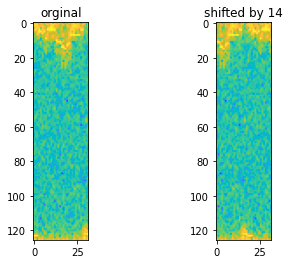

In [ ]:
plot_shited_spectrogram(train_x[0], shift=14)

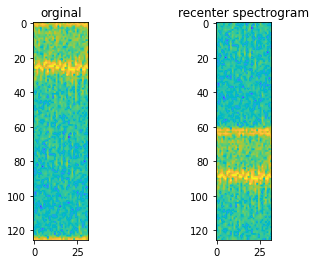

In [ ]:
plot_recenter_midline_spectrogram(train_x[6])

In [ ]:
#train_x = train_x.reshape(list(train_x.shape)+[1])

train_x = np.repeat(train_x[...,np.newaxis], 3, -1)

#val_x = val_x.reshape(list(val_x.shape)+[1])

val_x = np.repeat(val_x[...,np.newaxis], 3, -1)

In [ ]:
# Public test set - loading and preprocessing
test_path = 'MAFAT RADAR Challenge - Public Test Set V1'
test_df = load_data(test_path)
test_df = data_preprocess(test_df.copy())
test_x = test_df['iq_sweep_burst']
#test_x = test_x.reshape(list(test_x.shape)+[1])
test_x = np.repeat(test_x[...,np.newaxis], 3, -1)

**VGG-19**

In [ ]:
IMG_SHAPE = train_x.shape[1:]
base_model = VGG19(include_top = False, weights = 'imagenet', input_shape = IMG_SHAPE,pooling='avg')

Because the VGG-19 weights are already trained we would like to only train the new model layers. Thus, we will freeze the weights of the base model.

In [ ]:
base_model.trainable = False

In [ ]:
model= Sequential()
# model.add(Rescaling(1./255,input_shape = IMG_SHAPE))
model.add(base_model) 
# model.add(Flatten()) 
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 512)               20024384  
Total params: 20,024,384
Trainable params: 0
Non-trainable params: 20,024,384
_________________________________________________________________


In [ ]:
# model.add(Dense(256,activation=('relu'))) 
# model.add(Dropout(.2))
# model.add(Dense(128,activation=('relu')))
# model.add(Dropout(.2))

In [ ]:
# Final layer
model.add(Dense(1,activation=('sigmoid')))

# Sanity check
print(f"\nModel input shape:\n{model.input_shape}\nModel output shape:\n"\
f"{model.output_shape}\n\n\nModel summary:") 
model.summary()


Model input shape:
(None, 126, 32, 3)
Model output shape:
(None, 1)


Model summary:
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 512)               20024384  
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 513       
Total params: 20,024,897
Trainable params: 513
Non-trainable params: 20,024,384
_________________________________________________________________


In [ ]:
# Model is saved at the end of every epoch, if it's the best seen so far.
checkpoint_filepath = '/content/drive/My Drive/Final Project ITC/MAFAT Challenge/Saved Models/Nir/VGG-19_IDG_FULL_NO_PPF'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

earlystop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

In [ ]:
#Initializing the hyperparameters
batch_size= 2**5
initial_epochs=15
learn_rate=0.001
adam = Adam(learning_rate=learn_rate)

In [ ]:
#Fitting the Image Generator defined above to the X train data set
train_generator.fit(train_x)

In [ ]:
model.compile(optimizer=adam,loss='binary_crossentropy',metrics=[AUC(), 'accuracy'])

In [ ]:
history = model.fit(train_generator.flow(train_x, train_y, batch_size= batch_size),
                    epochs=initial_epochs,
                    validation_data=(val_x, val_y),
                    callbacks=[model_checkpoint_callback,earlystop],
                    verbose = 1)


                    # steps_per_epoch=len(train_x)/batch_size,
                    # validation_steps=len(val_x),

Epoch 1/15
206/206 [==============================] - 15s 71ms/step - loss: 0.4054 - auc_2: 0.8641 - accuracy: 0.8790 - val_loss: 0.6806 - val_auc_2: 0.7314 - val_accuracy: 0.5340
Epoch 2/15
206/206 [==============================] - 12s 57ms/step - loss: 0.2985 - auc_2: 0.9044 - accuracy: 0.9000 - val_loss: 0.6911 - val_auc_2: 0.7519 - val_accuracy: 0.5210
Epoch 3/15
206/206 [==============================] - 12s 56ms/step - loss: 0.2749 - auc_2: 0.9055 - accuracy: 0.9085 - val_loss: 0.7140 - val_auc_2: 0.7238 - val_accuracy: 0.5146
Epoch 4/15
206/206 [==============================] - 11s 55ms/step - loss: 0.2591 - auc_2: 0.9135 - accuracy: 0.9062 - val_loss: 0.7186 - val_auc_2: 0.7234 - val_accuracy: 0.5146
Epoch 5/15
 47/206 [=====>........................] - ETA: 7s - loss: 0.2670 - auc_2: 0.9023 - accuracy: 0.9155

In [ ]:
datagen = ImageDataGenerator() #preprocessing_function=resnet50_preprocess_input)
train_gen = datagen.flow(train_x, train_y, batch_size=batch_size)

In [ ]:
history_resnet50 = model.fit(train_gen,
          steps_per_epoch=len(train_x) // batch_size,
          epochs=no_epochs,
          validation_data=(val_x, val_y),
          validation_steps=len(val_x) // batch_size,
          callbacks=earlystop)
          

Epoch 1/30
410/410 [==============================] - 11s 27ms/step - loss: 0.3239 - auc: 0.8344 - accuracy: 0.8613 - val_loss: 0.7295 - val_auc: 0.7438 - val_accuracy: 0.5696
Epoch 2/30
410/410 [==============================] - 6s 15ms/step - loss: 0.2720 - auc: 0.8954 - accuracy: 0.8872 - val_loss: 0.7033 - val_auc: 0.7628 - val_accuracy: 0.5955
Epoch 3/30
410/410 [==============================] - 9s 23ms/step - loss: 0.2533 - auc: 0.9110 - accuracy: 0.8982 - val_loss: 0.7277 - val_auc: 0.7756 - val_accuracy: 0.6019
Epoch 4/30
410/410 [==============================] - 10s 24ms/step - loss: 0.2402 - auc: 0.9214 - accuracy: 0.9064 - val_loss: 0.6051 - val_auc: 0.7822 - val_accuracy: 0.6472
Epoch 5/30
410/410 [==============================] - 10s 24ms/step - loss: 0.2304 - auc: 0.9286 - accuracy: 0.9083 - val_loss: 0.5741 - val_auc: 0.7851 - val_accuracy: 0.6731
Epoch 6/30
410/410 [==============================] - 10s 25ms/step - loss: 0.2246 - auc: 0.9327 - accuracy: 0.9095 - val_

VGG19

In [ ]:
# Creating and running the model
model = create_model(VGG19, input_shape)  
model.compile(loss=loss_function, optimizer=optimizer, metrics=[AUC(), 'accuracy'])

datagen = ImageDataGenerator() #preprocessing_function=vgg19_preprocess_input)
train_gen = datagen.flow(train_x, train_y, batch_size=batch_size)

history_vgg19 = model.fit(train_gen,
          steps_per_epoch=len(train_x) // batch_size,
          epochs=no_epochs,
          validation_data=(val_x, val_y),
          validation_steps=len(val_x) // batch_size,
          callbacks=earlystop)
          

Epoch 1/30
410/410 [==============================] - 8s 19ms/step - loss: 0.4251 - auc_2: 0.7428 - accuracy: 0.8098 - val_loss: 0.6844 - val_auc_2: 0.7845 - val_accuracy: 0.6149
Epoch 2/30
410/410 [==============================] - 7s 17ms/step - loss: 0.2434 - auc_2: 0.9276 - accuracy: 0.9051 - val_loss: 0.6161 - val_auc_2: 0.8042 - val_accuracy: 0.6828
Epoch 3/30
410/410 [==============================] - 7s 17ms/step - loss: 0.2128 - auc_2: 0.9414 - accuracy: 0.9180 - val_loss: 0.5774 - val_auc_2: 0.8166 - val_accuracy: 0.6828
Epoch 4/30
410/410 [==============================] - 7s 17ms/step - loss: 0.1965 - auc_2: 0.9484 - accuracy: 0.9240 - val_loss: 0.5879 - val_auc_2: 0.8261 - val_accuracy: 0.6990
Epoch 5/30
410/410 [==============================] - 7s 17ms/step - loss: 0.1862 - auc_2: 0.9535 - accuracy: 0.9281 - val_loss: 0.5301 - val_auc_2: 0.8370 - val_accuracy: 0.7443
Epoch 6/30
410/410 [==============================] - 7s 17ms/step - loss: 0.1788 - auc_2: 0.9560 - accur

Inception resnet_v2 - 

problem - minimun input must be (75X75)

In [ ]:
# Creating and running the model
# model = create_model(InceptionResNetV2, input_shape)  
# model.compile(loss=loss_function, optimizer=optimizer, metrics=[AUC(), 'accuracy'])

# datagen = ImageDataGenerator(preprocessing_function=inception_resnet_v2_preprocess_input)
# train_gen = datagen.flow(train_x, train_y, batch_size=batch_size)

# history_inception_resv2 = model.fit(train_gen,
#           steps_per_epoch=len(train_x) // batch_size,
#           epochs=no_epochs,
#           validation_data=(val_x, val_y),
#           validation_steps=len(val_x) // batch_size,
#           callbacks=earlystop)
          

#### **Results**

In [ ]:
def plot_loss_and_accuracy_over_epoches(history, num_epoches):

  fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
  ax1.plot(history.history['loss'][:num_epoches], color='b', label="Training loss")
  ax1.plot(history.history['val_loss'][:num_epoches], color='r', label="validation loss")
  ax1.set_yticks(np.arange(0, 1, 0.1))
  ax1.set_title("Loss over epoches")
  ax1.grid()
  legend = ax1.legend(loc='best', shadow=True)

  ax2.plot(history.history['accuracy'][:num_epoches], color='b', label="Training accuracy")
  ax2.plot(history.history['val_accuracy'][:num_epoches], color='r',label="Validation accuracy")
  ax2.set_title("accuracy over epoches")
  ax2.grid()


  legend = plt.legend(loc='best', shadow=True)
  plt.tight_layout()
  plt.show()

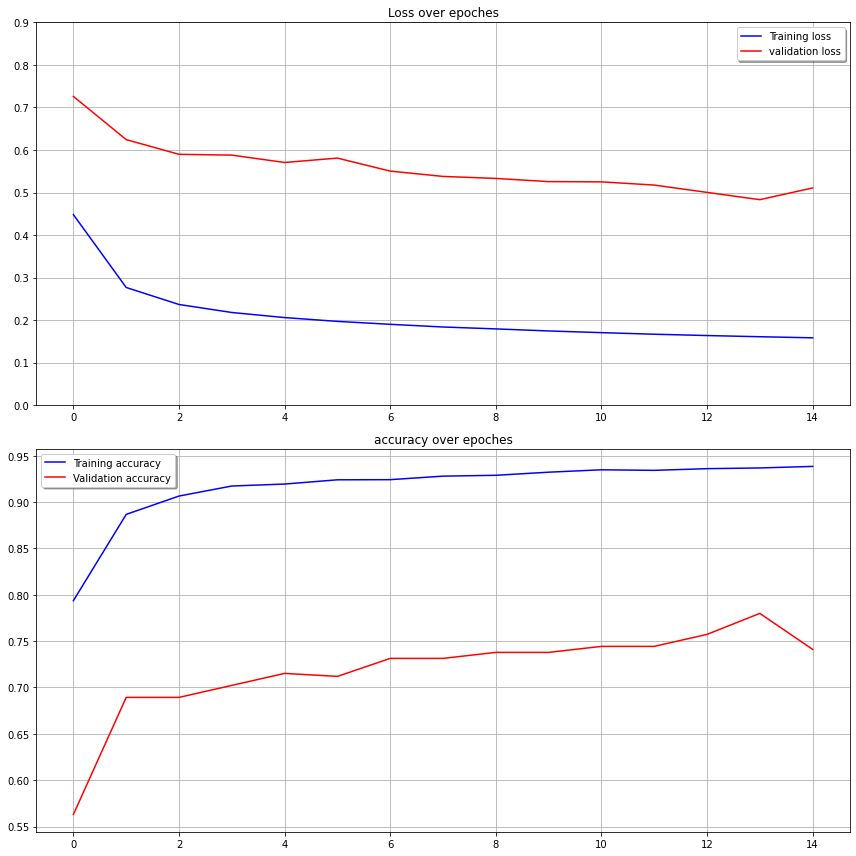

In [ ]:
plot_loss_and_accuracy_over_epoches(history, 15)

## Comments
* We can see the model begins to overfit after 11 epochs.

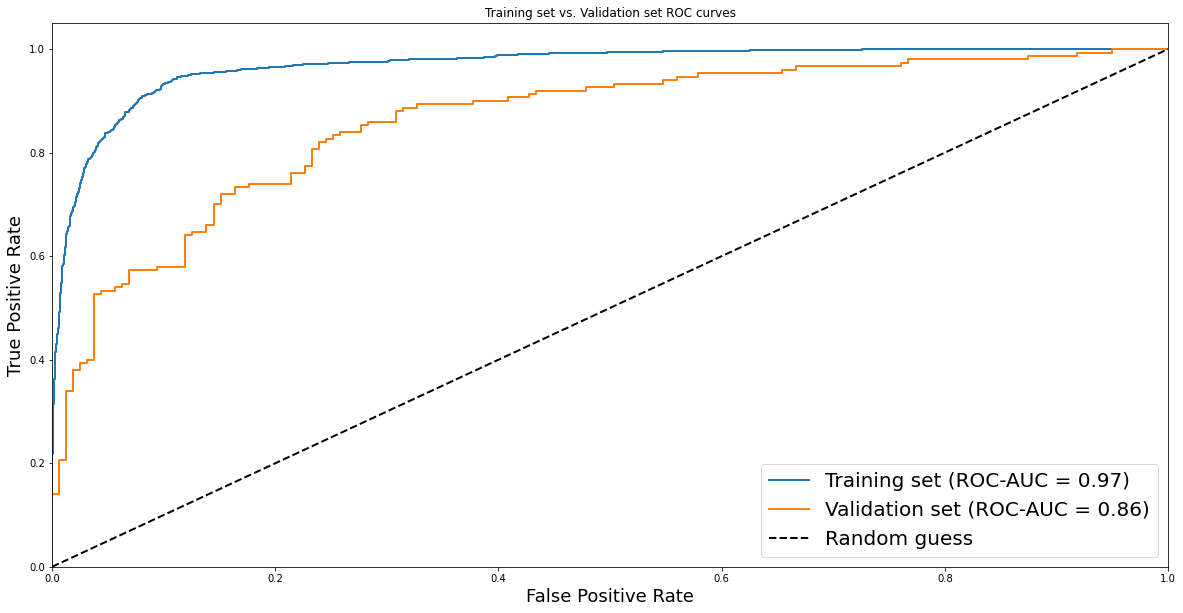

In [ ]:
# Plot ROC curve and show ROC-AUC results of the training and validation sets. 
pred = [model.predict(train_x), model.predict(val_x)]
actual = [train_y, val_y]
stats(pred, actual)

In [ ]:
model_input = {
                'model_conf' : {
                              'batch_size':16,
                              'loss_function':BinaryCrossentropy(),
                              'no_epochs':50,
                              'optimizer':Adam(learning_rate = 0.001),
                              },
               'callback' : {'early_stop':{
                                          'flag':True,
                                          'early_stop':EarlyStopping(monitor='val_accuracy', patience=5, verbose=1)
                                          },
                            'model_checkpoint':{
                                                'flag':True,
                                                'file_path':'/content/drive/My Drive/Final Project ITC/MAFAT Challenge/Saved Models/Nir/VGG-19_IDG_FULL_NO_PPF',
                                                'save_weights_only':False,
                                                'monitor':'val_accuracy'
                                                }
                            },
               'IDG' : {
                        'vertical_flip':True,
                        'horizontal_flip':True,
                        'width_shift_range' : 0.9,
                        'height_shift_range': 0.05,
                        'fill_mode':'nearest',
                        'brightness_range' : [0.7,1.1],
                        'preprocessing_function' : recenter_midline
                        }        
                }



In [ ]:
model_input['model_conf']['batch_size']

16